DepreSys4 data variables are saved in separate netcdf files for T, U, and V grids. Altough lat/lon values are different for these grids, same dimension and coordinate names are in netcdf files. Hence, it would be wrong to combine these data files using `xr.merge` as grid info will not correct. A user first needs to rename dimensions and update coordinate values before combinging the data files. 

A working example is shown below. We combine cell area variables and save them in a separate nc file. These variables are required for area-weighted means.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
# Read Data Files

path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"

ds_T = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-T.nc")

ds_U = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-U.nc")

ds_V = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-V.nc")

As shown below, if we try to combine these files, we would get an error. This is because coordinate values do not match as these are on different grids. Thus, these coordinate should have different names as well. 

In [10]:
A = xr.merge([ds_T.area, ds_U.area, ds_V.area])

MergeError: conflicting values for variable 'nav_lat' on objects to be combined:
first value: <xarray.Variable (y: 1207, x: 1442)>
array([[-89.5     , -89.5     , -89.5     , ..., -89.5     , -89.5     ,
        -89.5     ],
       [-89.4875  , -89.4875  , -89.4875  , ..., -89.4875  , -89.4875  ,
        -89.4875  ],
       [-89.475   , -89.475   , -89.475   , ..., -89.475   , -89.475   ,
        -89.475   ],
       ...,
       [ 49.995502,  49.995502,  49.995502, ...,  50.018894,  49.995502,
         49.995502],
       [ 50.      ,  50.      ,  50.      , ...,  50.019047,  50.      ,
         50.      ],
       [ 49.995502,  49.995502,  49.995502, ...,  50.018894,  49.995502,
         49.995502]], dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    nav_model:      grid_T
    bounds:         bounds_lat
second value: <xarray.Variable (y: 1207, x: 1442)>
array([[-89.49687 , -89.49687 , -89.49687 , ..., -89.49687 , -89.49687 ,
        -89.49687 ],
       [-89.484375, -89.484375, -89.484375, ..., -89.484375, -89.484375,
        -89.484375],
       [-89.47188 , -89.47188 , -89.47188 , ..., -89.47188 , -89.47188 ,
        -89.47188 ],
       ...,
       [ 49.99404 ,  49.99404 ,  50.004257, ...,  50.004257,  49.99404 ,
         49.99404 ],
       [ 49.99881 ,  49.99881 ,  50.00658 , ...,  50.00658 ,  49.99881 ,
         49.99881 ],
       [ 49.99404 ,  49.99404 ,  50.004257, ...,  50.004257,  49.99404 ,
         49.99404 ]], dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    nav_model:      grid_U
    bounds:         bounds_lat

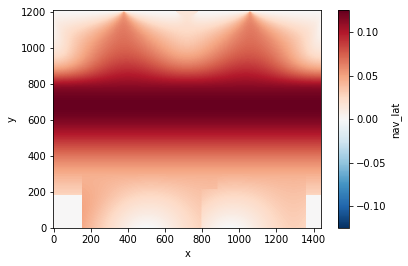

In [13]:
(ds_V.nav_lat - ds_T.nav_lat).plot()

In [37]:
# Create a new dataset 

ds_area = xr.Dataset()
ds_area['area_t'] = ds_T['area'] #.isel(x=slice(750,1200), y = slice(700, 1150))

ds_area['xu'] = xr.DataArray(ds_area.x.values + 0.5, dims=['xu'])
ds_area['yv'] = xr.DataArray(ds_area.y.values + 0.5, dims=['yv'])

ds_area['area_u'] = xr.DataArray(ds_U['area'].values, dims=['y','xu'])
ds_area['area_v'] = xr.DataArray(ds_V['area'].values, dims=['yv','x'])

ds_area['nav_lat_u'] = xr.DataArray(ds_U['nav_lat'].values, dims=['y','xu'])
ds_area['nav_lat_v'] = xr.DataArray(ds_V['nav_lat'].values, dims=['yv','x'])

ds_area['nav_lon_u'] = xr.DataArray(ds_U['nav_lon'].values, dims=['y','xu'])
ds_area['nav_lon_v'] = xr.DataArray(ds_V['nav_lon'].values, dims=['yv','x'])

ds_area = ds_area.isel(x=slice(750,1200), y = slice(700, 1150), xu=slice(750,1200), yv = slice(700, 1150))

#DX = xr.DataArray(dx,coords=[("yh",lat), ("xh",lon)])
#DY = xr.DataArray(dy,coords=[("yh",lat), ("xh",lon)])

In [34]:
ds_area

<xarray.Dataset>
Dimensions:    (x: 450, xu: 450, y: 450, yv: 450)
Coordinates:
    nav_lat    (y, x) float32 ...
    nav_lon    (y, x) float32 ...
Dimensions without coordinates: x, xu, y, yv
Data variables:
    area_t     (y, x) float32 ...
    area_u     (y, xu) float32 769070600.0 769070600.0 ... 165005570.0
    area_v     (yv, x) float32 768833100.0 768833100.0 ... 164911630.0
    nav_lat_u  (y, xu) float32 3.9967546 3.9967546 ... 73.288826 73.184616
    nav_lat_v  (yv, x) float32 4.121441 4.121441 4.121441 ... 73.36482 73.26051
    nav_lon_u  (y, xu) float32 -99.625 -99.375 -99.125 ... 51.32521 51.486984
    nav_lon_v  (yv, x) float32 -99.75 -99.5 -99.25 ... 51.430058 51.591553

In [39]:
save_path="/home/users/hkhatri/DePreSys4_Data/Ensemble_Data/Data_Consolidated/"

ds_area.to_netcdf(save_path + 'Area.nc')